In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**LIBRARIES**

In [24]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.signal import savgol_filter


**LOAD THE DATASET**

In [3]:
dataset_path = "/content/drive/My Drive/mhealth+dataset (1)/MHEALTHDATASET"

columns = [
    'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
    'ecg_chest_1', 'ecg_chest_2',
    'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
    'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
    'magnet_ankle_x', 'magnet_ankle_y', 'magnet_ankle_z',
    'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
    'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
    'magnet_arm_x', 'magnet_arm_y', 'magnet_arm_z',
    'activity'
]

activity_labels = {
    1: 'Standing still', 2: 'Sitting and relaxing', 3: 'Lying down',
    4: 'Walking', 5: 'Climbing stairs', 6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 8: 'Knees bending (crouching)',
    9: 'Cycling', 10: 'Jogging', 11: 'Running', 12: 'Jump front & back'
}


**SEGMENTATION**

In [4]:
def load_mhealth_data(path):
    all_data = []
    for file in sorted(os.listdir(path)):
        if file.endswith('.log'):
            df = pd.read_csv(os.path.join(path, file), delim_whitespace=True, header=None)
            df.columns = columns
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

df = load_mhealth_data(dataset_path)
scaler = StandardScaler()
df[columns[:-1]] = scaler.fit_transform(df[columns[:-1]])


In [5]:
def segment_data(data, window_size=80, step=40):
    X, y = [], []
    for start in range(0, len(data) - window_size, step):
        end = start + window_size
        segment = data.iloc[start:end]
        if len(segment['activity'].unique()) == 1:
            X.append(segment.drop('activity', axis=1).values)
            y.append(segment['activity'].iloc[0])
    return np.array(X), np.array(y)

X, y = segment_data(df)
y_encoded = to_categorical(y - 1)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


**LSTM MODEL**

In [6]:
model = Sequential([
    InputLayer(input_shape=X.shape[1:]),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 80, 128)        │        77,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,172 (516.30 KB)

 Trainable params: 132,172 (516.30 KB)

 Non-trainable params: 0 (0.00 B)

**TRAIN THE MODEL**

In [8]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

start = time.time()
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks,
                    verbose=1)
end = time.time()


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 101s 538ms/step - accuracy: 0.9200 - loss: 0.1875 - val_accuracy: 0.9135 - val_loss: 0.2035 - learning_rate: 5.0000e-04
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 86s 461ms/step - accuracy: 0.9215 - loss: 0.1891 - val_accuracy: 0.9194 - val_loss: 0.2000 - learning_rate: 5.0000e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 138s 438ms/step - accuracy: 0.9250 - loss: 0.1769 - val_accuracy: 0.9161 - val_loss: 0.2027 - learning_rate: 5.0000e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 86s 458ms/step - accuracy: 0.9230 - loss: 0.1840 - val_accuracy: 0.9191 - val_loss: 0.2020 - learning_rate: 5.0000e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 141s 452ms/step - accuracy: 0.9245 - loss: 0.1770 - val_accuracy: 0.9197 - val_loss: 0.1937 - learning_rate: 5.0000e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 158s 537ms/step - accuracy: 0.9258 - loss: 0.1808 - val_accuracy: 0.9196 - val_loss: 0.1958 - learning_rate: 5.0000e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 13

**ACCUARACY AND LOSS CURVES**

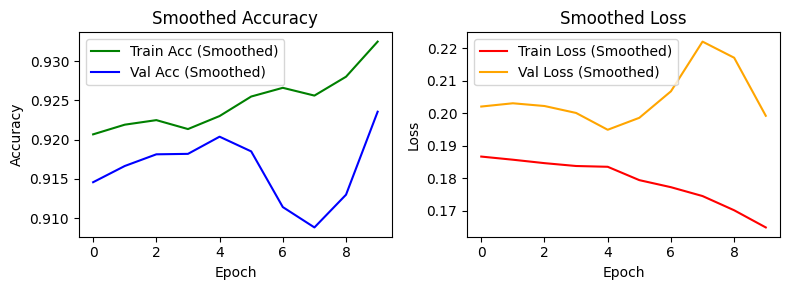

In [17]:
from scipy.signal import savgol_filter

# Use only if len(history.history['accuracy']) >= 7
window = 5 if len(history.history['accuracy']) >= 7 else 3
poly = 2

train_acc = savgol_filter(history.history['accuracy'], window, poly)
val_acc = savgol_filter(history.history['val_accuracy'], window, poly)
train_loss = savgol_filter(history.history['loss'], window, poly)
val_loss = savgol_filter(history.history['val_loss'], window, poly)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Acc (Smoothed)", color='green')
plt.plot(val_acc, label="Val Acc (Smoothed)", color='blue')
plt.title("Smoothed Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss (Smoothed)", color='red')
plt.plot(val_loss, label="Val Loss (Smoothed)", color='orange')
plt.title("Smoothed Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


**EVALUATION**

187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step


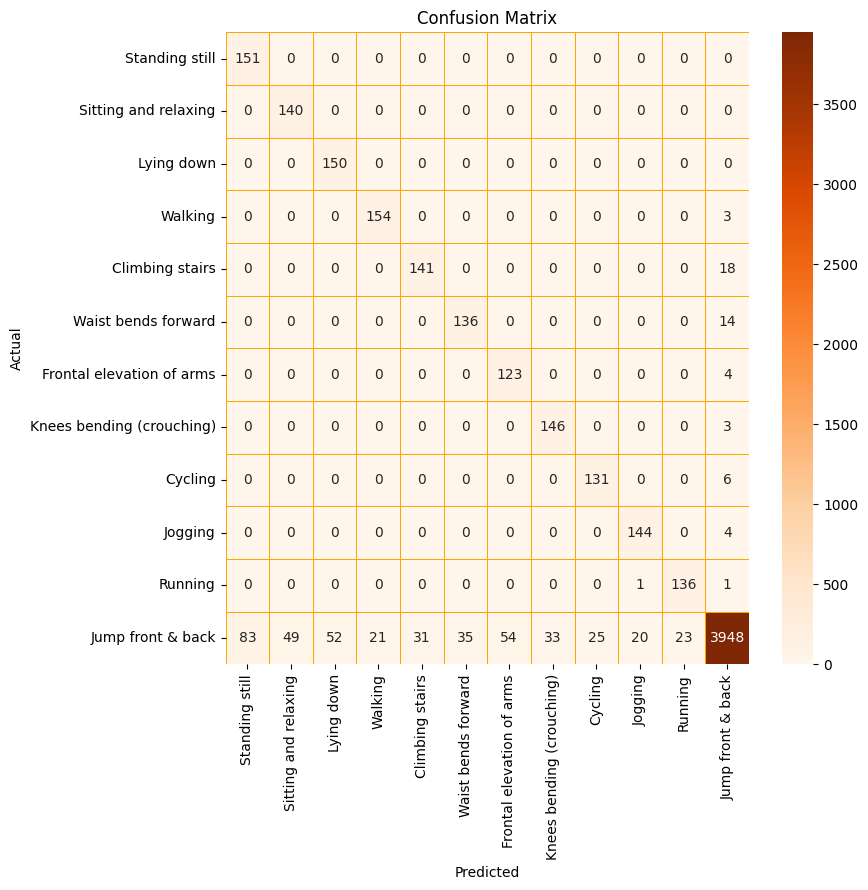

📊 Classification Report:
                           precision    recall  f1-score   support

           Standing still       0.65      1.00      0.78       151
     Sitting and relaxing       0.74      1.00      0.85       140
               Lying down       0.74      1.00      0.85       150
                  Walking       0.88      0.98      0.93       157
          Climbing stairs       0.82      0.89      0.85       159
      Waist bends forward       0.80      0.91      0.85       150
Frontal elevation of arms       0.69      0.97      0.81       127
Knees bending (crouching)       0.82      0.98      0.89       149
                  Cycling       0.84      0.96      0.89       137
                  Jogging       0.87      0.97      0.92       148
                  Running       0.86      0.99      0.92       138
        Jump front & back       0.99      0.90      0.94      4374

                 accuracy                           0.92      5980
                macro avg       0.8

In [20]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=activity_labels.values(),
            yticklabels=activity_labels.values(),
            linewidths=0.5, linecolor='Orange')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.tight_layout(); plt.show()

# Classification Report
print("📊 Classification Report:")
report = classification_report(y_true_labels, y_pred_labels, target_names=activity_labels.values(), output_dict=True)
print(classification_report(y_true_labels, y_pred_labels, target_names=activity_labels.values()))

# Sensitivity & Specificity
accuracy = np.mean(y_pred_labels == y_true_labels)
mse = mean_squared_error(y_true_labels, y_pred_labels)
sensitivity = np.mean([report[label]['recall'] for label in activity_labels.values()])

specificity_list = []
for i in range(len(activity_labels)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp_fn = cm.sum() - cm[:, i].sum()
    specificity_list.append(tn / fp_fn if fp_fn != 0 else 0)
specificity = np.mean(specificity_list)

print(f"\n✅ Final Evaluation:")
print(f"✔️ Accuracy     : {accuracy * 100:.2f}%")
print(f"✔️ Sensitivity  : {sensitivity:.4f}")
print(f"✔️ Specificity  : {specificity:.4f}")
print(f"✔️ MSE          : {mse:.4f}")
print(f"✔️ Training Time: {end - start:.2f} sec")


In [21]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"\n🎯 Train Accuracy: {train_acc*100:.2f}% | Loss: {train_loss:.4f}")
print(f"📊 Val Accuracy: {val_acc*100:.2f}%   | Loss: {val_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc*100:.2f}% | Loss: {test_loss:.4f}")



🎯 Train Accuracy: 93.00% | Loss: 0.1619
📊 Val Accuracy: 92.24%   | Loss: 0.1937
✅ Test Accuracy: 91.97% | Loss: 0.1937


**ROC CURVE**

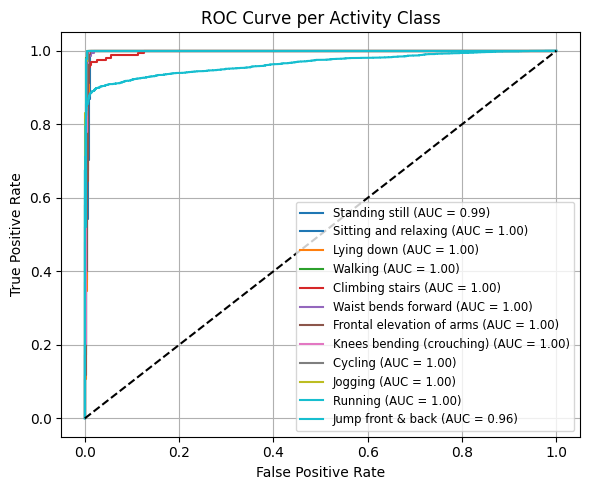

In [26]:
fpr = dict(); tpr = dict(); roc_auc = dict()
n_classes = y_test.shape[1]
colors = plt.cm.get_cmap('tab10', n_classes).colors

plt.figure(figsize=(6, 5))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i],
             label=f"{activity_labels[i+1]} (AUC = {roc_auc[i]:.2f})",
             color=colors[i % len(colors)])

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve per Activity Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()
